# Multiarm Bandit

**ONE ARMED BANDIT** is a slang for a _slot machine_: It has one arm (one leaver) and it will rob you. Imagine, however, that there is not one but many such bandits. Some are worse than others, and some may even reward you. The problem, however, is that they all look the same, and we do not know how bad each one of the is. Since there are many, each with only one hand, the multitude of slot machines is referred to as **MULTIARM BANDIT**. 

In our case we will use **RESOURCE** as synonim for **BANDIT**. Problem we are solving is **RESOURCE ALLOCATION**.

***This is wide set of problems:***
- Medical Trials Allocation
- Content Recommendation
- Ad Placement
- Dynamic Pricing
- Portfolio Management
- A/B testing

## Basic imports

In [140]:
from typing import Iterable
import random

import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange

## Envirovment simulation

### Simulate Resoucre

**RESOURCE** can represent single Ad, medicine, version of web page etc. In our case each Resource has predefined reward distribution that is unknown during decision making. We can only sample from this distribution. It is simulation of real-world scenarion where we can "sample" from unknown distribution by selecting specific Resource.

In [141]:
class Resource:
    """A resource (bandit) with uniform reward distribution.

    This class represents a resource (bandit) with a uniform reward distribution.
    Regardless of the received action, the resource returns rewards that are uniformly
    sampled from the segment [`mean` - `span`, `mean` + `span`].

    Attributes:
        mean (float): Mean (expected) value of the reward.
        span (float): Span of the reward.
        p (float, optional): Probability of the mean to be updated. Defaults to 0.
        means (list[float]): List to store the mean values over time.
    """

    def __init__(self, mean: float, span: float, p: float = 0):
        """Initialize the resource.

        Args:
            mean (float): Mean (expected) value of the reward.
            span (float): Span of the reward.
            p (float, optional): Probability of the mean to be updated. Defaults to 0.
        """
        self.mean = mean
        self.span = span
        self.p = p
        self.means = [self.mean]

    def select_and_get_reward(self) -> float:
        """Pull leaver and obtain reward.

        Returns:
            float: The obtained reward.
        """
        if self.p > random.uniform(0, 1):
            self.mean += random.uniform(-0.05, 0.05) * self.mean
            
        return self.mean + 2 * self.span * (random.random() - 0.5)  # random number in [mean-span, mean+span]


### Testing one Resource

Resource with static reward distribution

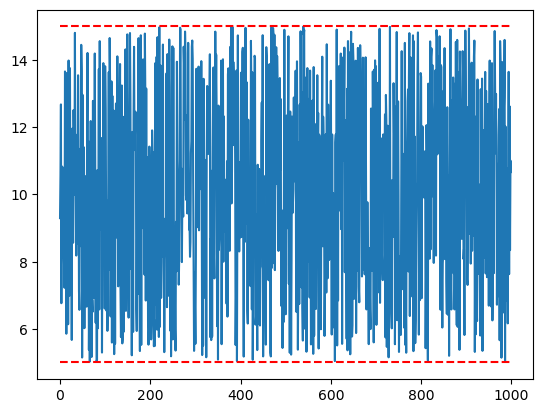

In [142]:
test_mean = 10.0
test_span = 5.0
test_len = 1000

test_resource = Resource(test_mean, test_span)
test_rewards = [test_resource.select_and_get_reward() for _ in range(test_len)]

plt.plot(test_rewards, label="rewards")
plt.plot((test_mean+test_span)*np.ones(test_len), linestyle="--", color="r")
plt.plot((test_mean-test_span)*np.ones(test_len), linestyle="--", color="r")

Resource with dinamyc reward distribution

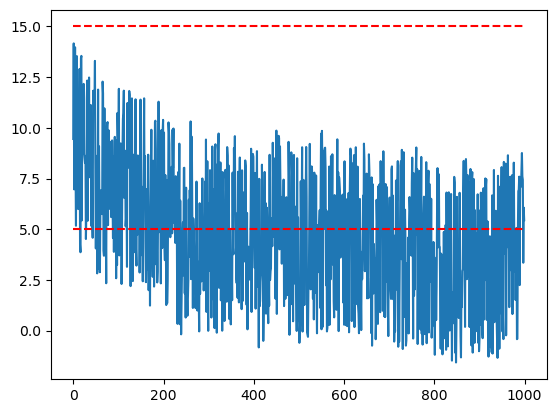

In [143]:
test_resource = Resource(test_mean, test_span, p=0.5)
test_rewards = [test_resource.select_and_get_reward() for _ in range(test_len)]

plt.plot(test_rewards, label="rewards")
plt.plot((test_mean+test_span)*np.ones(test_len), linestyle="--", color="r")
plt.plot((test_mean-test_span)*np.ones(test_len), linestyle="--", color="r")

### Building an envirovment of multiple Resources

Our goal here is to define envirovment of multiple Resources. We can dinamicly allocate resources and get their rewards.

In [144]:
class ResourcesEnvironment:
    """An environment consisting of multiple Resources."""

    def __init__(self, resources: Iterable[Resource], penalty=1000):
        """Initialize the environment.

        Args:
            resources (iter[Resource]): Resources to be used within the environment.
            penalty (int, optional): 
                If the external agents attempts to use a resource not in the list,
                i.e. if the chosen action is negative or bigger than the index of
                the last resource, the returned reward will be `-penalty`. Defaults to 1000.
        """
        self.resources: list[Resource] = list(resources)
        self.penalty = penalty

    def take_action(self, a: int):
        """
        Select resource `a` and pull get its reward. 
        
        If the selected agent is valid, return the obtained reward.
        Otherwise, return negative penalty.
        """
        if a<0 or a>=len(self.resources):
            return -self.penalty
        else:
            return self.resources[a].select_and_get_reward()

### Testing the Environment

In [145]:
test_env_size = 5
test_resources = [Resource(i**2, i, p=0.5) for i in range(test_env_size)]
test_env = ResourcesEnvironment(test_resources)

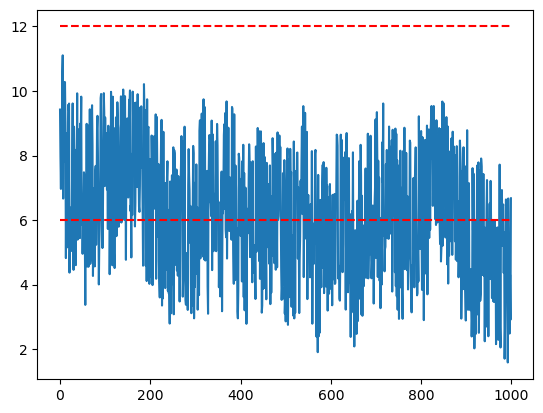

In [146]:
selected_resource = 3
test_rewards = [test_env.take_action(selected_resource) for _ in range(test_len)]

plt.plot(test_rewards, label="rewards")
plt.plot((selected_resource**2+selected_resource)*np.ones(test_len), linestyle="--", color="r")
plt.plot((selected_resource**2-selected_resource)*np.ones(test_len), linestyle="--", color="r")

Then, we will test if the environment behaves correctly when an invalid action is given...

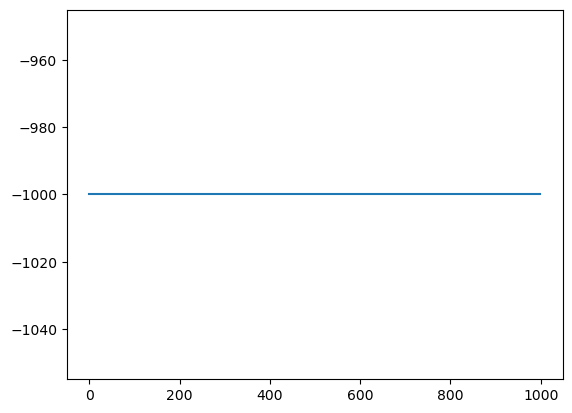

In [147]:
selected_resource = -1
test_rewards = [test_env.take_action(selected_resource) for _ in range(test_len)]

plt.plot(test_rewards, label="rewards")

In [148]:
test_rewards = [test_env.take_action(random.randint(0, 4)) for _ in range(test_len)]
test_mean = sum(test_rewards)/test_len

print("TEST MEAN = ", test_mean)

TEST MEAN =  4.678735678455776


## Decision Policies

In [149]:
def choose_greedy_action(q):
    return np.argmax(q)

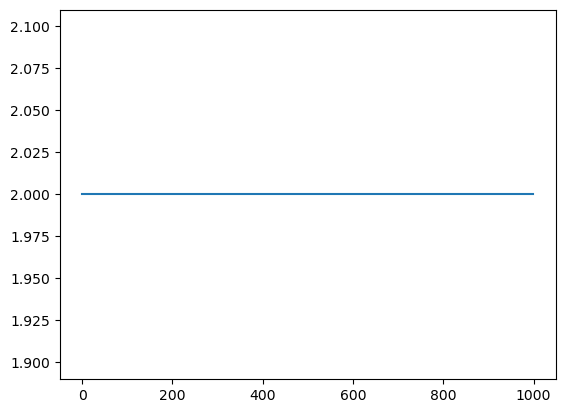

In [150]:
test_q = [1, 2, 3, 2, 1]

test_actions = [choose_greedy_action(test_q) for _ in range(test_len)]

plt.plot(test_actions)

In [151]:
def choose_random_action(n):
    return random.randint(0, n-1)

In [152]:
def choose_eps_greedy_action(q, eps):
    if random.random() > eps:
        return choose_greedy_action(q)
    else:
        return choose_random_action(len(q))

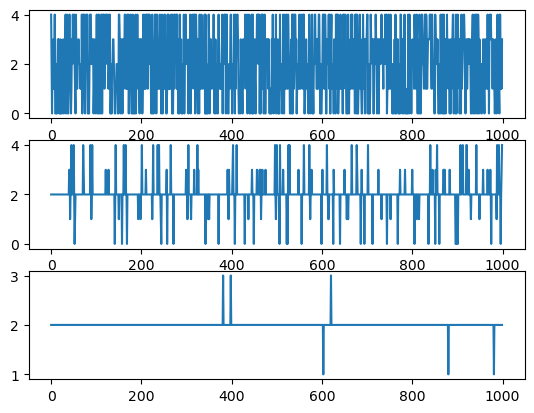

In [153]:
plt.subplot(3, 1, 1)
plt.plot([choose_eps_greedy_action(test_q, 1.0) for _ in range(test_len)])
plt.subplot(3, 1, 2)
plt.plot([choose_eps_greedy_action(test_q, 0.2) for _ in range(test_len)])
plt.subplot(3, 1, 3)
plt.plot([choose_eps_greedy_action(test_q, 0.01) for _ in range(test_len)])

## Training Loop

In [154]:
def training_loop(env, n_resources, n_steps=1000, alpha=0.1, epsilon=0.1, dynamic_eps=False, high_eps=0.8, low_eps=0.001):
    q = [0] * n_resources
    rewards = [0] * n_steps  # Pre-allocate memory for rewards
    q_over_time = [[] for _ in range(n_resources)]  # List to store q values for each resource

    if not dynamic_eps:
        for t in trange(n_steps):
            a = choose_eps_greedy_action(q, epsilon)
            r = env.take_action(a)
            q[a] += alpha * (r - q[a])

            rewards[t] = r  # Assign reward directly, no need to append
            for i in range(n_resources):
                q_over_time[i].append(q[i])  # Track q values for each resource
    else:
        n_half = n_steps // 2
        for t in trange(n_steps):
            selected_eps = high_eps if t < n_half else low_eps

            a = choose_eps_greedy_action(q, selected_eps)
            r = env.take_action(a)
            q[a] += alpha * (r - q[a])

            rewards[t] = r  # Assign reward directly, no need to append
            for i in range(n_resources):
                q_over_time[i].append(q[i])  # Track q values for each resource

    return q, rewards, q_over_time


In [155]:
def plot_q_over_time(q_over_time, env):
    for i in range(len(q_over_time)):
        plt.plot(q_over_time[i])
        plt.axhline(y=env.resources[i].mean, color='r', linestyle='--')
        plt.xlabel('Steps')
        plt.ylabel('Q Value')
        plt.title(f'Q Values Over Time for Resource {i}')
    plt.show()

In [170]:
def plot_best_q_over_time(q_over_time):
    transposed_q = np.array(q_over_time).T
    
    # Define colors and legend labels
    colors = ['red', 'green', 'yellow', 'blue', 'pink']
    legend_labels = ['Resource 1', 'Resource 2', 'Resource 3', 'Resource 4', 'Resource 5']

    # Initialize legend handles
    legend_handles = []

    # Iterate over each index and create legend handles
    for i, color in enumerate(colors):
        handle = plt.Line2D([], [], marker='o', color=color, linestyle='None', label=legend_labels[i])
        legend_handles.append(handle)

    # Iterate over each time step
    for t, q in enumerate(transposed_q):
        max_i = q.argmax()  # Index of maximum Q-value
        max_q = q[max_i]    # Maximum Q-value

        # Plot the maximum Q-value at the current time step with its corresponding color
        plt.scatter(t, max_q, color=colors[max_i])

    # Add legend with manual handles and labels
    plt.legend(handles=legend_handles, loc='best')

    plt.xlabel('Time Step')
    plt.ylabel('Maximum Q-Value')
    plt.title('Resource Allocation Over Time')
    plt.show()

In [157]:
def test_loop(env, q):
    total_reward = 0
    num_steps = 1000  # Number of steps in the test loop
    for _ in range(num_steps):
        action = choose_greedy_action(q)  # Choose action using the learned q values without exploration
        reward = env.take_action(action)
        total_reward += reward
    return total_reward / num_steps  # Return average reward per step

In [158]:
resources = [Resource(5, 1,),
             Resource(10, 9),
             Resource(2, 1),
             Resource(6, 3),
             Resource(8, 1)]

env = ResourcesEnvironment(resources)

In [159]:
ideal_performance = max(env.resources[i].mean for i in range(len(resources)))
ideal_performance

10

In [160]:
q, rewards, _ = training_loop(env, n_resources=len(resources), n_steps=1000, alpha=0.1, epsilon=0.1, dynamic_eps=False)

100%|██████████| 1000/1000 [00:00<00:00, 208713.38it/s]


In [161]:
q

[5.033552476432932,
 6.166470144131269,
 1.732618509016455,
 5.806000894602191,
 7.971116807756876]

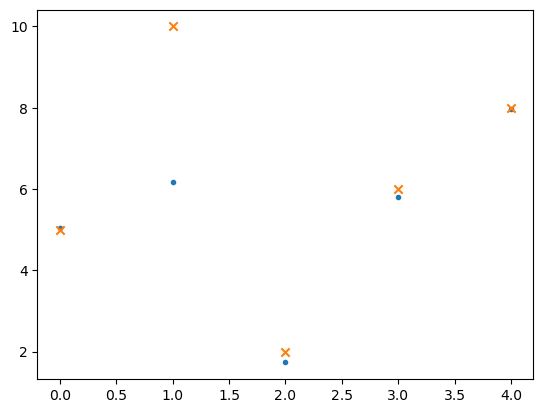

In [162]:
plt.scatter(range(len(q)), q, marker=".")
plt.scatter(range(len(q)), [r.mean for r in env.resources], marker="x")

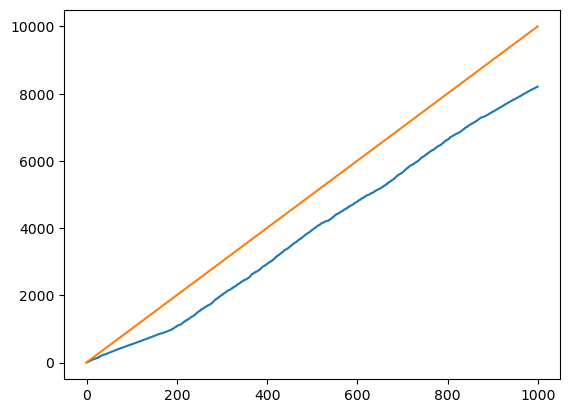

In [163]:
g = np.cumsum(rewards)
max_r = max([b.mean for b in env.resources])
plt.plot(g)
plt.plot(np.cumsum(max_r * np.ones(len(g))))

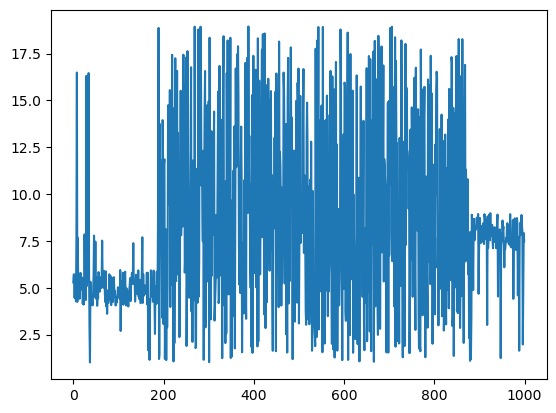

In [164]:
plt.plot(rewards)

## Exploring vs Exploiting

### Exploration (High epsilon)

- Exploration involves trying out new actions to gather information about the environment.
- It allows the agent to discover potentially better actions or learn more about the dynamics of the environment.
- By exploring, the agent can improve its understanding of the environment and potentially identify optimal strategies in the long term.

### Exploitation (Low epsilon)

- Exploitation involves leveraging the agent's current knowledge to select actions that are believed to be the best based on past experiences.
- It aims to maximize immediate rewards by consistently choosing actions that have proven to be effective in the past.
- Exploitation is beneficial when the agent has already learned a lot about the environment and wants to exploit this knowledge to maximize short-term gains.

In [165]:
HIGH_EPSILON = 0.8
LOW_EPSILON = 0.01

100%|██████████| 1000/1000 [00:00<00:00, 278654.27it/s]


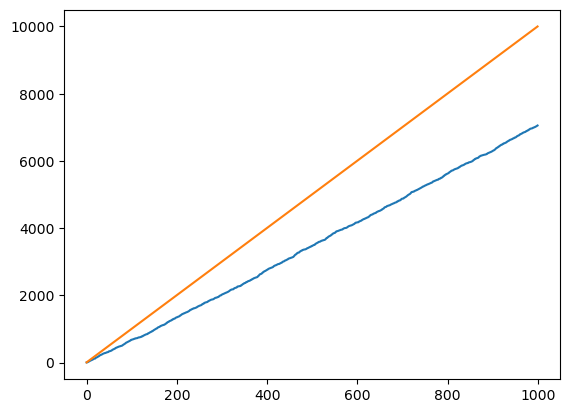

In [166]:
q, rewards, q_over_time = training_loop(env, n_resources=len(resources), n_steps=1000, alpha=0.1, epsilon=HIGH_EPSILON)

g = np.cumsum(rewards)
max_r = max([b.mean for b in env.resources])
plt.plot(g)
plt.plot(np.cumsum(max_r * np.ones(len(g))))

In [167]:
test_performance = test_loop(env, q)
test_performance

7.958377662953214

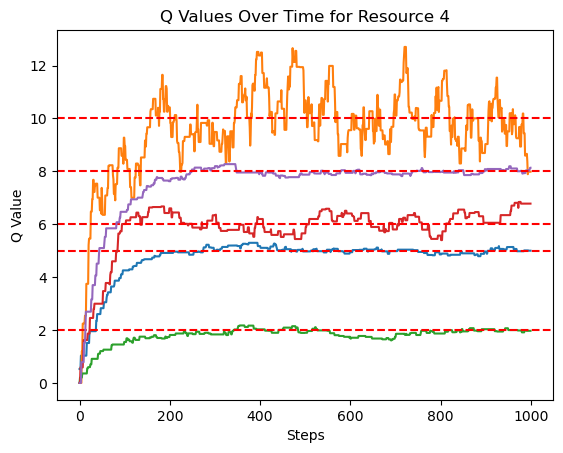

In [168]:
plot_q_over_time(q_over_time, env)

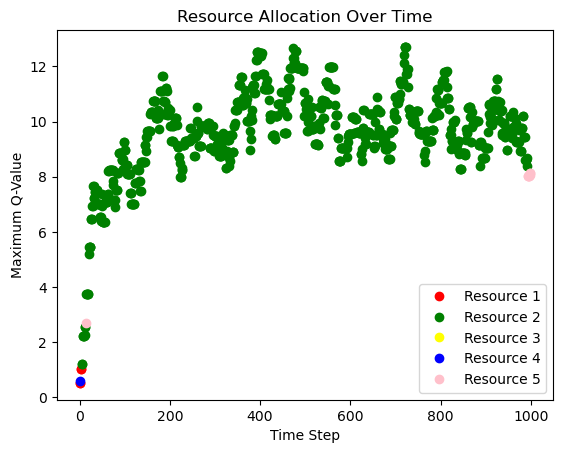

In [171]:
plot_best_q_over_time(q_over_time)

100%|██████████| 1000/1000 [00:00<00:00, 208900.49it/s]


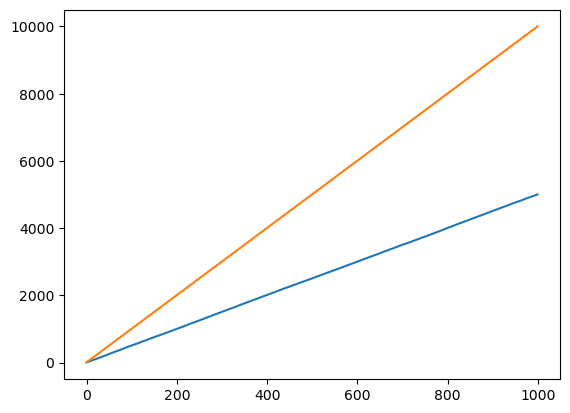

In [172]:
q, rewards, q_over_time = training_loop(env, n_resources=len(resources), n_steps=1000, alpha=0.1, epsilon=LOW_EPSILON)

g = np.cumsum(rewards)
max_r = max([b.mean for b in env.resources])
plt.plot(g)
plt.plot(np.cumsum(max_r * np.ones(len(g))))

In [173]:
test_performance = test_loop(env, q)
test_performance

4.988589842391095

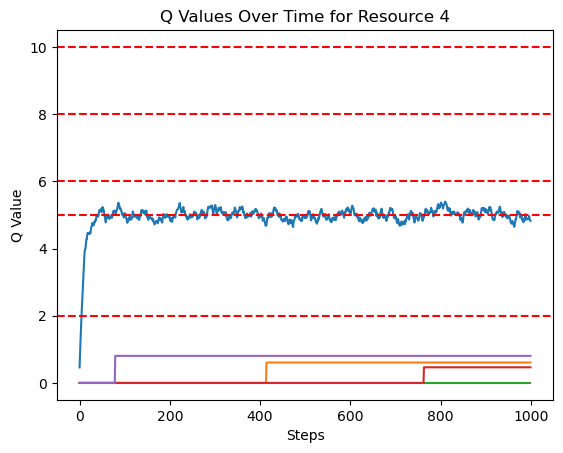

In [174]:
plot_q_over_time(q_over_time, env)

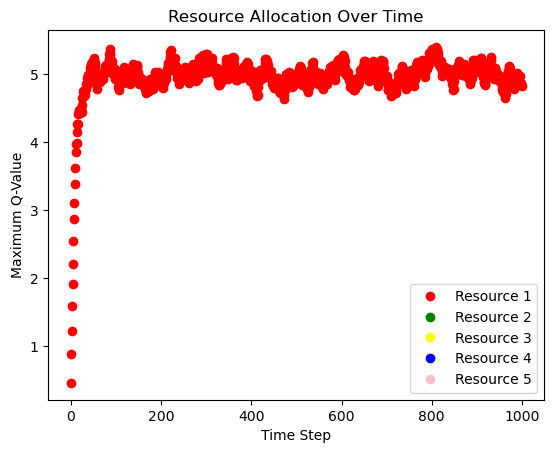

In [175]:
plot_best_q_over_time(q_over_time)

In [176]:
q

[4.822590250715985,
 0.6072106776994803,
 0,
 0.4654651194895202,
 0.8052652053509904]

100%|██████████| 10000/10000 [00:00<00:00, 254463.96it/s]


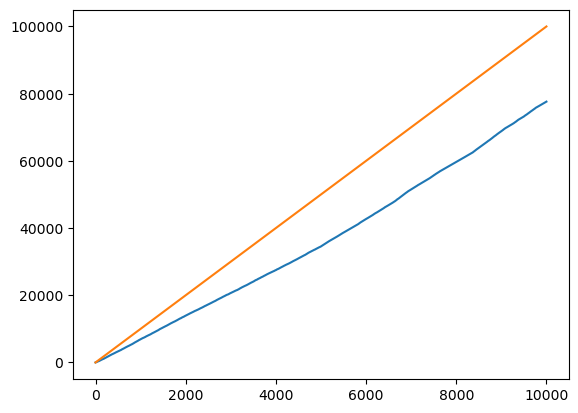

In [177]:
q, rewards, q_over_time = training_loop(env, n_resources=len(resources), n_steps=10000, alpha=0.1, dynamic_eps=True, low_eps=0.1, high_eps=0.8)

g = np.cumsum(rewards)
max_r = max([b.mean for b in env.resources])
plt.plot(g)
plt.plot(np.cumsum(max_r * np.ones(len(g))))

In [178]:
test_performance = test_loop(env, q)
test_performance

7.996528134251009

In [179]:
q

[4.972838420680004,
 7.628885590040828,
 2.0122822018921385,
 5.963462869601862,
 7.924229572840184]

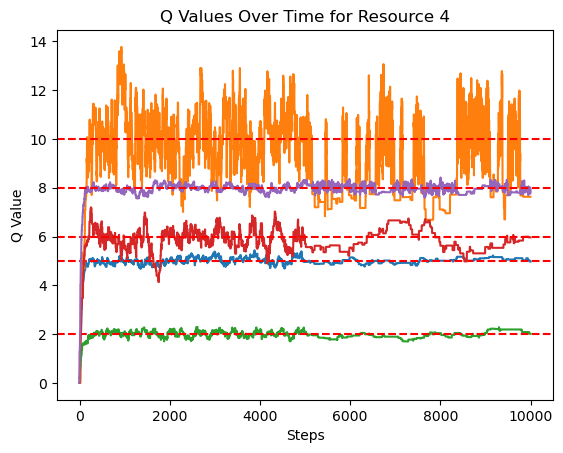

In [180]:
plot_q_over_time(q_over_time, env)

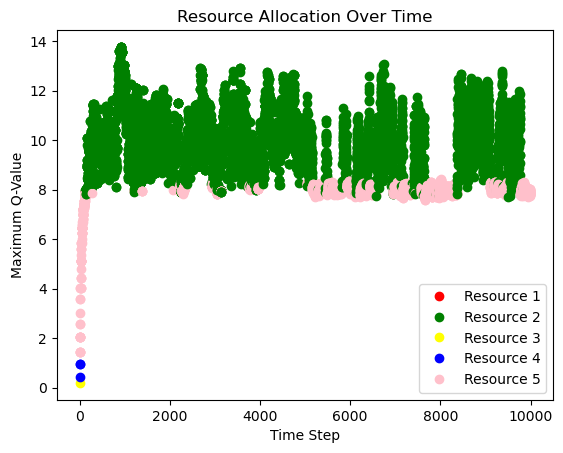

In [181]:
plot_best_q_over_time(q_over_time)

Dynamic reward distribution

In [182]:
resources = bandits = [Resource(5, 1, p=0.1),
                       Resource(10, 9, p=0.01),
                       Resource(2, 1, p=0.5),
                       Resource(6, 3, p=0.1),
                       Resource(8, 1, p=0.1)]

env = ResourcesEnvironment(resources)

100%|██████████| 10000/10000 [00:00<00:00, 218381.68it/s]


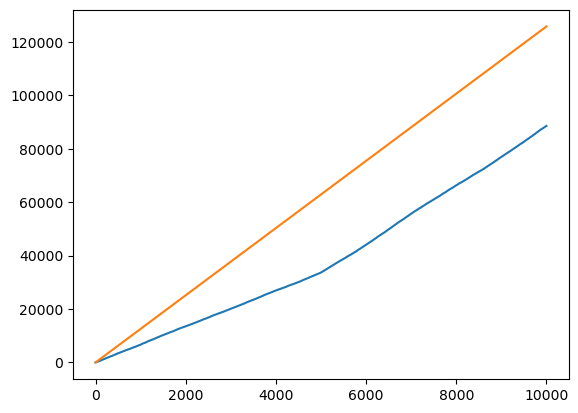

In [183]:
q, rewards, q_over_time = training_loop(env, n_resources=len(resources), n_steps=10000, alpha=0.1, dynamic_eps=True, low_eps=0.1, high_eps=0.8)

g = np.cumsum(rewards)
max_r = max([b.mean for b in env.resources])
plt.plot(g)
plt.plot(np.cumsum(max_r * np.ones(len(g))))

In [184]:
test_performance = test_loop(env, q)
test_performance

12.124216413584039

In [185]:
q

[4.722117809625814,
 13.307607700484192,
 2.124143633293738,
 5.002526362722253,
 5.902523866876169]

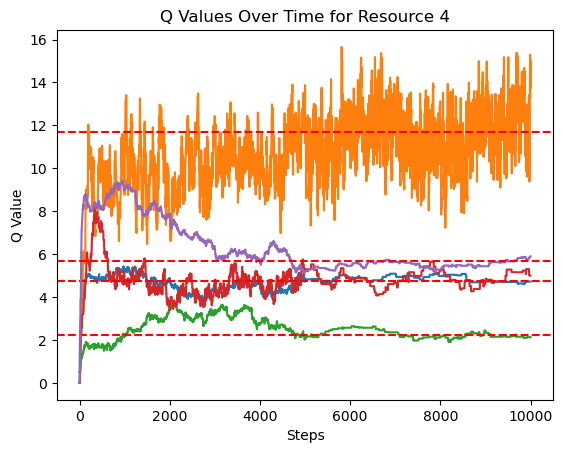

In [186]:
plot_q_over_time(q_over_time, env)

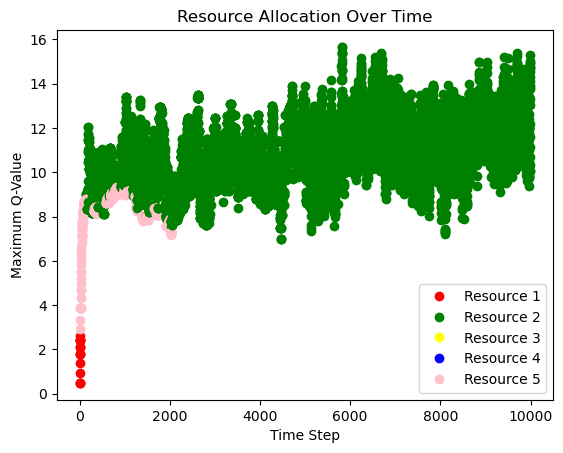

In [187]:
plot_best_q_over_time(q_over_time)